# Goal: explore which model performes the best with the MVP dataset

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()
%matplotlib notebook

data_path = os. getcwd()[:-9] +'Data/'

In [2]:
df =  pd.read_csv(data_path+'df_mvp.csv')
df.time_bin = pd.to_datetime(df.time_bin)

In [3]:
df.head(3)

,time_bin,label,source,current_popularity,wind_speed,temp,status_good,status_maybe,status_bad,dayofweek,hour
0,2020-03-23 14:35:00,0.0,mis/imp,42.0,26.598094,37.846753,0.0,0.0,1.0,0,14
1,2020-03-23 14:50:00,0.0,obs,42.0,25.900000,37.940000,0.0,0.0,1.0,0,14
2,2020-03-23 15:05:00,0.0,mis/imp,43.0,26.427817,38.125302,0.0,0.0,1.0,0,15


## Performance of the last model
The best random forest model so far has the following performance: 
ROC AUC=0.858

     precision    recall  f1-score   support

         0.0       0.79      0.76      0.78        84
         1.0       0.78      0.80      0.79        86

    accuracy                           0.78       170
    macro avg       0.78      0.78      0.78       170
    weighted avg       0.78      0.78      0.78       170


After exploring more ways to feature enginneering, we decided to try the following changes:
- Remove "status_maybe" as it highly correlate with the other status column
- Instead of using "dayofweek" and "hour", separte them into weekday 5-8pm and weekend. 

I will test each of the two ideas out by training separate models.

## A random forest model without "status_maybe"

In [4]:
from sklearn.model_selection import train_test_split
X = df[['current_popularity','wind_speed','temp','status_good','status_bad','dayofweek','hour']]
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [6]:
from sklearn.metrics import classification_report

predictions = rfc.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.76      0.77      0.76        84
         1.0       0.77      0.76      0.76        86

    accuracy                           0.76       170
   macro avg       0.76      0.76      0.76       170
weighted avg       0.76      0.76      0.76       170



In [7]:
from sklearn.metrics import roc_auc_score, roc_curve

def roc_auc(model,model_name, X_test, y_test):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(model_name+': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(); plt.show()

No Skill: ROC AUC=0.500
rfc: ROC AUC=0.856


<IPython.core.display.Javascript object>


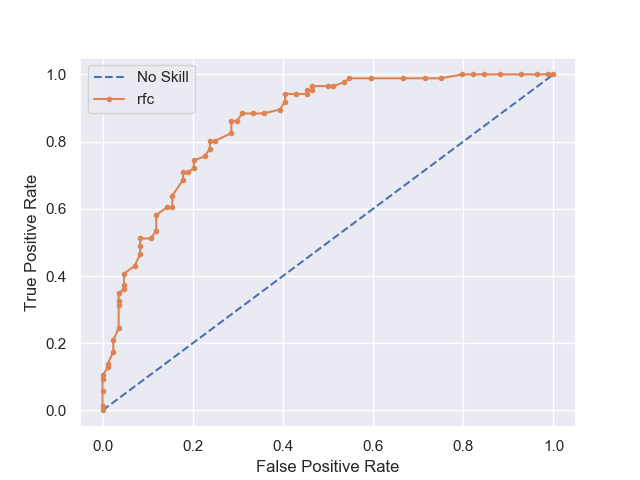

In [8]:
roc_auc(rfc,'rfc', X_test, y_test)

In [9]:
sorted(list(zip(X.columns,rfc.feature_importances_)), key = lambda x: x[1],reverse=True) 

[('temp', 0.27740774519401684),
 ('current_popularity', 0.2252835874898668),
 ('wind_speed', 0.18207400169102975),
 ('hour', 0.16603226609598776),
 ('dayofweek', 0.09945889636810364),
 ('status_good', 0.027991860118632993),
 ('status_bad', 0.021751643042362323)]

#### results of removing "status_maybe"
- model performance reduced by a small amount. 
- Instead of removing it, how about combining the three status to one columns with them marked as 1,2,3?

## A random forest model with all status combine into one columns

In [11]:
df['status_all'] = df['status_good'] + df['status_maybe'] *2 +df['status_bad'] *3

In [12]:
X_s = df[['current_popularity','wind_speed','temp','status_all','dayofweek','hour']]
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y, test_size=0.33, random_state=42)

In [13]:
rfc_s = RandomForestClassifier(random_state=0).fit(X_train_s, y_train_s)

In [14]:
predictions_s = rfc_s.predict(X_test_s)
print(classification_report(y_test_s,predictions_s))

              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77        84
         1.0       0.78      0.78      0.78        86

    accuracy                           0.78       170
   macro avg       0.78      0.78      0.78       170
weighted avg       0.78      0.78      0.78       170



No Skill: ROC AUC=0.500
rfc_s: ROC AUC=0.857


<IPython.core.display.Javascript object>


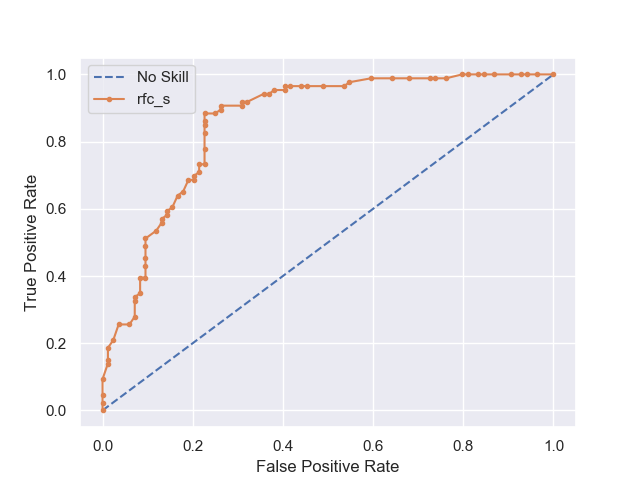

In [15]:
roc_auc(rfc_s,'rfc_s', X_test_s, y_test_s)

In [38]:
sorted(list(zip(X_s.columns,rfc_s.feature_importances_)), key = lambda x: x[1],reverse=True) 

[('temp', 0.28953513226398275),
 ('current_popularity', 0.22560761912531044),
 ('wind_speed', 0.1781588419880761),
 ('hour', 0.16581677006641904),
 ('dayofweek', 0.09099414536598288),
 ('status_all', 0.049887491190228894)]

#### results of combining all status to one columns
- compared to the original model, model performance is one point lower
- but one point better than the model without "status_maybe"

## Train a random forest model with engineered time

In [70]:
# enginer the time. Two columns: column one checks if the time is weekday 5pm to 8pm; column two checks for weekend. 
import numpy as np

df['weekday_17to20'] = np.zeros(len(df))
df.loc[(df.dayofweek < 5) & ((df.hour >= 17) & (df.hour <= 20 )),'weekday_17to20'] =1

df['weekend'] = np.zeros(len(df))
df.loc[df.dayofweek > 5, 'weekend'] =1

In [76]:
X_t = df[['current_popularity','wind_speed','temp','status_good','status_maybe','status_bad','weekday_17to20','weekend']]
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y, test_size=0.33, random_state=42)

In [77]:
rfc_t = RandomForestClassifier(random_state=0).fit(X_train_t, y_train_t)

In [78]:
predictions_t = rfc_t.predict(X_test_t)
print(classification_report(y_test_t,predictions_t))

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79        84
         1.0       0.80      0.77      0.79        86

    accuracy                           0.79       170
   macro avg       0.79      0.79      0.79       170
weighted avg       0.79      0.79      0.79       170



No Skill: ROC AUC=0.500
rfc_t: ROC AUC=0.844


<IPython.core.display.Javascript object>


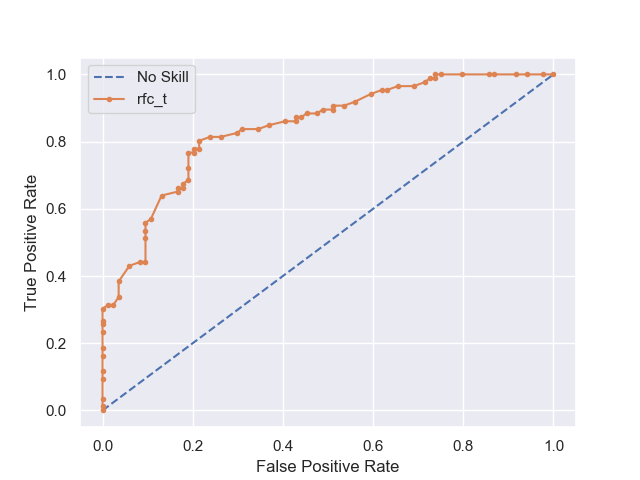

In [79]:
roc_auc(rfc_t,'rfc_t', X_test_t, y_test_t)

In [80]:
sorted(list(zip(X_t.columns,rfc_t.feature_importances_)), key = lambda x: x[1],reverse=True) 

[('temp', 0.3484307419250326),
 ('current_popularity', 0.2951984169081921),
 ('wind_speed', 0.24539328240068464),
 ('weekday_17to20', 0.030455531660794462),
 ('status_good', 0.022932460974874034),
 ('weekend', 0.02130132860160381),
 ('status_maybe', 0.021185658520014874),
 ('status_bad', 0.01510257900880337)]

#### results of engineering time
- compared to the original model, model performed similarly on precision and recall, but has worse AUC. 
- Thus, use the original model for now. 